# Ropes

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/partices/Ropes.ipynb)

This example simulates ropes as nodes connected by slightly deformable sticks.

In [1]:
%pip install --quiet phiflow
from phi.jax.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.
from tqdm.notebook import trange

We start by scattering nodes as a jittered grid and setting some of them as fixed points while the rest will be able to move.

<Figure size 288x216 with 2 Axes>

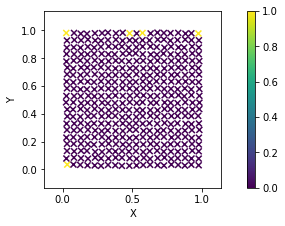

In [50]:
grid = CenteredGrid(0, x=20, y=20, bounds=Box(x=1, y=1))
x = pack_dims(grid.points, 'x,y', instance('nodes'))
x += math.random_uniform(x.shape) * .01
fixed_indices = vec(nodes=[399, 19, 199, 239, 0])
fixed = math.scatter(math.zeros(instance(x), dtype=bool), fixed_indices, True)
plot(PointCloud(x, fixed), size=(4, 3))

We represent our rope system using a `Graph` whose edges encode the stick lengths.
The sticks are represented by the graph's edge matrix, which we store in sparse COO format here. 

<Figure size 864x360 with 2 Axes>

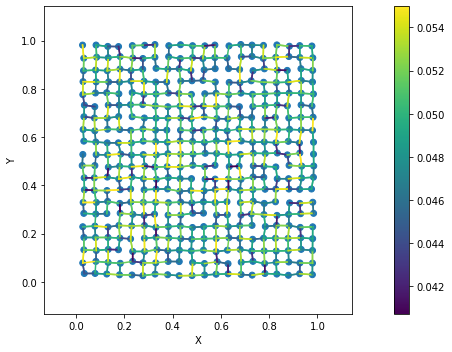

In [54]:
deltas = math.pairwise_differences(x, max_distance=grid.dx.mean * 1.1, format='coo')
distances = math.vec_length(deltas)
graph = geom.Graph(x, distances, {}, deltas, distances)
plot(graph)

Now let's define the simulation!
After handling the gravity and velocity updates, we perform a fixed number of relaxation steps.

Each relaxation step shifts the node positions in order to reduce stretching or squishing of the sticks.
To do this, we first compute the stick centers and directions.
For an unstretched stick, the node position must be half the stick's length away from its center along the stick's direction.
For nodes with multiple connected sticks, we compute the ideal node position for each stick, and then average the so-obtained positions.

In [61]:
@jit_compile
def step(graph: geom.Graph, v, dt=1., gravity=vec(x=0, y=-0.01), relaxation_steps=50):
    v += gravity * dt
    x = graph.center + math.where(fixed, 0, dt * v)
    for _ in range(relaxation_steps):
        deltas = math.pairwise_differences(x, format=graph.edges)
        stick_centers = x + .5 * deltas
        stick_directions = math.vec_normalize(deltas, epsilon=1e-5)
        next_x = stick_centers - stick_directions * .5 * graph.edges
        next_x = math.mean(next_x, dual)
        x = math.where(fixed, x, next_x)
    v = (x - graph.center) / dt
    return geom.Graph(x, graph.edges, {}), v

In [62]:
v0 = math.zeros_like(x)
graph_trj, v_trj = iterate(step, batch(time=50), graph, v0, substeps=2)

In [63]:
plot(graph_trj, animate='time')

c:\phd\phiflow2\phiml\phiml\math\_tensors.py:427: SyntaxWarning: Indexing without item names is not recommended. Got indices (entriesⁱ=1311)
  return gather(self, item)
